# Importiamo le librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Per regressione multipla
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1: Regressione Lineare Semplice Polinomiale

## 1.1: Definiamo le funzioni

In [2]:
def f(x, alpha):
    d = alpha.shape[0] - 1 # Abbiamo detto che la shape di alpha è (d+1, )
    y = np.zeros_like(x)
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

def vandermonde(x, d):
    n = x.shape[0]
    X = np.zeros((n, d+1)) # d+1 perchè le colonne vanno da x^0 a x^k
    for i in range(d+1):
        X[:, i] = x ** i # Prendi tutti gli elementi della prima colonna x^0
    return X

## 1.2: Risoluzione tramite SVD:
$$
X = U \Sigma V^T,
$$

Dove $U \in \mathbb{R}^{n \times n}$ e $V \in \mathbb{R}^{(d+1) \times (d+1)}$ sono matrici ortogonali, mentre $\Sigma \in \mathbb{R}^{n \times (d+1)}$ è una matrice diagonale i cui elementi sulla diagonale sono i valori singolari di $X$, in ordine decrescente.

Ricordando che le matrici $U$ e $V$ sono ortognali, le equazioni normali diventano:

$$
X^T X \alpha = X^T y \iff V \Sigma^2 V^T \alpha = V \Sigma U^T y \iff \Sigma^2 V^T \alpha = \Sigma U^T y
$$

La cui soluzione esplicita è:

$$
    \alpha = \sum_{i=1}^{d+1} \frac{u_i^T y}{\sigma_i} v_i. 
$$

In [3]:
def SVD (X, y, tol=1e-6):
    # n = X righe (dati), p = X colonne (features/grado+1)
    n_features, p = X.shape
    
    # Calcoliamo la SVD di X
    U, s, VT = np.linalg.svd(X, full_matrices=False) # full_matrices per essere più veloce

    # Inizializzazione di alpha
    alpha = np.zeros((p, ))

    # Calcola alpha
    for i in range(p):
        if s[i] > tol: # Nel caso che s[i] sia troppo piccolo
            uTy = U[:, i].T @ y # Proiezione di y su U
            v_i = VT[i, :] # i-esima riga della colonna V
            alpha = alpha + uTy / s[i] * v_i 
    return alpha

## 1.2: Definiamo i dati di valori pseudo-casuali

In [4]:
d = 3
n = 15

alpha_true = np.ones((d+1,))

x = np.linspace(0, 1, n)
X = vandermonde(x, d) # Questa matrice ha il rango massimo

sig = 0.1
e = np.random.normal(loc=0, scale=sig, size=(n, ))

y = np.zeros_like(x)
for i in range(n):
    y[i] = f(x[i], alpha_true) + e[i]

alpha = SVD(X, y)
print(alpha)

[1.08976456 0.70584073 1.8186022  0.16184973]


## 1.3: Grafico

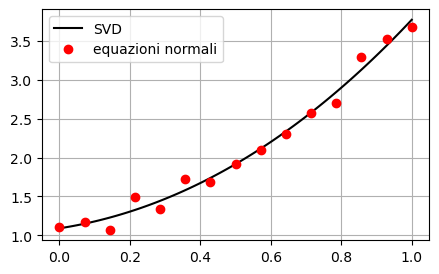

In [5]:
xx = np.linspace(0, 1, 100)
yy_svd = f(xx, alpha)

plt.figure(figsize=(5, 3))
plt.plot(xx, yy_svd, 'k')
plt.plot(x, y, 'ro')
plt.legend(["SVD", "equazioni normali", "True"])
plt.grid()
plt.savefig("grafico_simple_regression.png", dpi=300, bbox_inches='tight')
plt.show()

---
## 2: Database di Kaggle per Regressione Lineare Semplice


Prime 5 righe del dataset:
   Unnamed: 0  YearsExperience   Salary
0           0              1.2  39344.0
1           1              1.4  46206.0
2           2              1.6  37732.0
3           3              2.1  43526.0
4           4              2.3  39892.0
Ci sono 30 righe


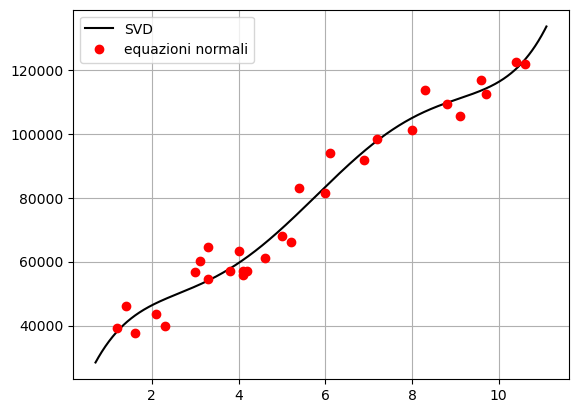

In [6]:
nome_file = 'Salary_dataset.csv'
df_student = pd.read_csv(nome_file)

print("\nPrime 5 righe del dataset:")
print(df_student.head())

x_raw = df_student['YearsExperience'].values
y_raw = df_student['Salary'].values

print(f"Ci sono {x_raw.shape[0]} righe")

d_salary = 5
X = vandermonde(x_raw, d_salary)

alpha = SVD(X, y_raw)

# Calcoliamo un pò di margine
x_min, x_max = x_raw.min(), x_raw.max()
xx = np.linspace(x_min - 0.5, x_max + 0.5, 1000)
yy_svd = f(xx, alpha)

plt.plot(xx, yy_svd, 'k')
plt.plot(x_raw, y_raw, 'ro')
plt.legend(["SVD", "equazioni normali", "True"])
plt.grid()
plt.show()


---
# 3: Regressione Multipla

Vai a vedere quando è buono il MSE (Mean Square Error).

$R^2$ è un numero compreso tra $0$ e $1$:
$$R^2 = 1 - \frac{\sum_{i=1}^n(\tilde y_i'-y_{Ti})^2}{\sum_{i=1}^n (\bar y - y_{Ti})^2}$$
Dove: 
- $y_{Ti}$ sono i dati reali nella fase di testing.
- $\bar y$ equivale alla media di $y_{Ti}$
- $\bar y_i$ equivale a $f(\bar x) \in$ test set 

In poche parole è $1-\frac{\text{Errore del modello}}{\text{Errore della Media}}$. Più il valore si avvicina ad 1, più è accurato.

In [7]:
nome_file = 'Student_Performance.csv'
df_student = pd.read_csv(nome_file)

print("\nPrime 5 righe del dataset:")
print(df_student.head())

x_raw = df_student.drop("Performance Index", axis=1) # Prende tutto tranne l'ultima colonna
x_raw["Extracurricular Activities"] = x_raw["Extracurricular Activities"].map({'Yes': 1, 'No':0})
y_raw = df_student["Performance Index"]
students = x_raw.shape[0]
features = x_raw.shape[1]

print(f"Ci sono {students} studenti")
print(f"Ci sono {features} features")

# hstack concatena orizzontalmente
ones_col = np.ones((students, 1))
X = np.hstack((ones_col, x_raw))

alpha = SVD(X, y_raw)
y_pred = X @ alpha


Prime 5 righe del dataset:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  
Ci sono 10000 studenti
Ci sono 5 features


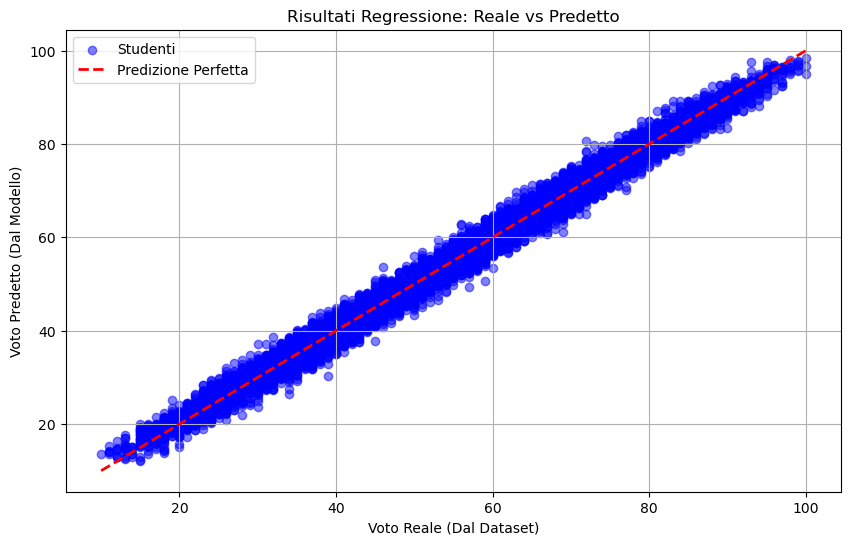

In [8]:
plt.figure(figsize=(10,6))

# Disegna i punti (Reale vs Predetto)
plt.scatter(y_raw, y_pred, color='blue', alpha=0.5, label='Studenti')

# Disegna la linea di "Perfezione" (y = x)
# Se un punto cade su questa linea rossa, vuol dire che il modello ha indovinato ESATTAMENTE il voto.
min_val = y_raw.min()
max_val = y_raw.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predizione Perfetta')

plt.title("Risultati Regressione: Reale vs Predetto")
plt.xlabel("Voto Reale (Dal Dataset)")
plt.ylabel("Voto Predetto (Dal Modello)")
plt.legend()
plt.grid(True)
plt.savefig("risultato_grafico.png", dpi=300, bbox_inches='tight')
plt.show()

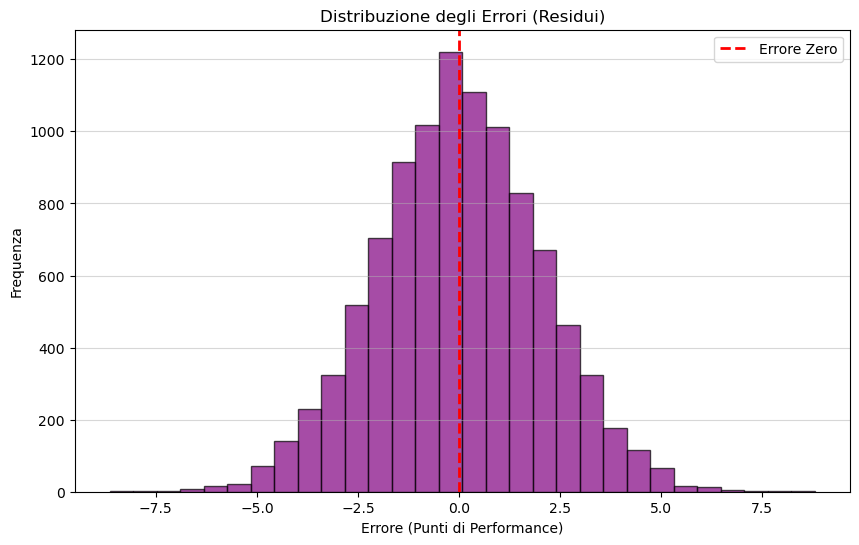

In [9]:
residuals = y_raw - y_pred

plt.figure(figsize=(10, 6))

# Istogramma
plt.hist(residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label="Errore Zero")

plt.title("Distribuzione degli Errori (Residui)")
plt.xlabel("Errore (Punti di Performance)")
plt.ylabel("Frequenza")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

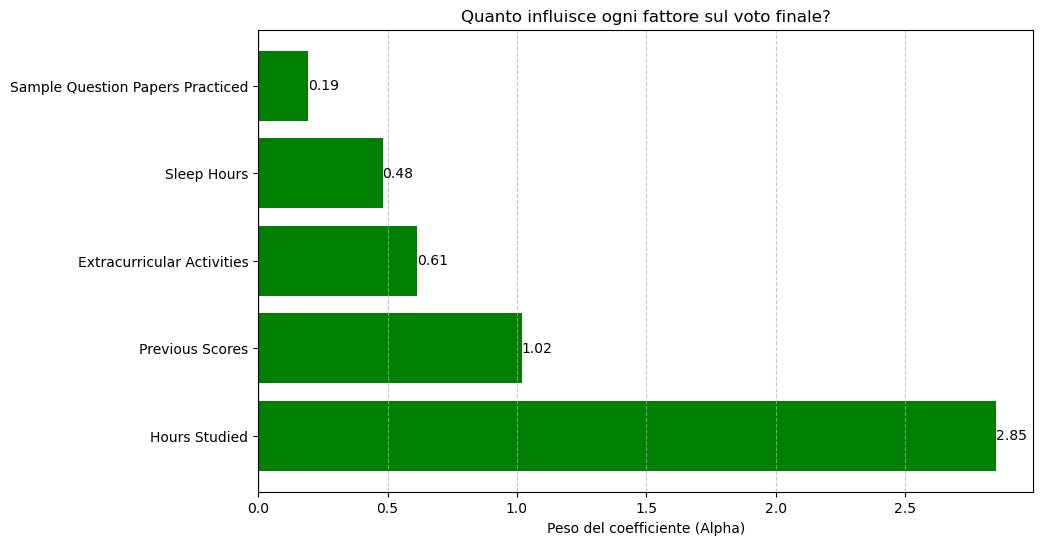

In [10]:
# Nomi delle features (escludiamo la colonna di "uni" aggiunta manualmente)
feature_names = x_raw.columns 

# I coefficienti (escludiamo alpha[0] che è l'intercetta/bias)
coefficients = alpha[1:] 

plt.figure(figsize=(10, 6))

# Creiamo un grafico a barre orizzontali
# Usiamo un trucco per i colori: verde se positivo, rosso se negativo
colors = ['green' if c > 0 else 'red' for c in coefficients]

plt.barh(feature_names, coefficients, color=colors)
plt.axvline(0, color='black', linewidth=0.8) # Linea dello zero

plt.title("Quanto influisce ogni fattore sul voto finale?")
plt.xlabel("Peso del coefficiente (Alpha)")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Aggiungiamo i valori accanto alle barre per chiarezza
for index, value in enumerate(coefficients):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.show()

## Come farlo veramente:

In [11]:
# Scegliamo il modello
model = LinearRegression()

model.fit(x_raw, y_raw)

y_pred_sklearn = model.predict(x_raw)

print("Coefficienti (Features) - sklearn:")
print(model.coef_)

print("Coefficienti (Features) - mio:") # sono uguali, il primo numero è il bias
print(alpha)

# L'intercetta (alpha[0] nel tuo codice manuale)
print(f"\nIntercetta (Bias): {model.intercept_}")

# Errore
rmse = np.sqrt(mean_squared_error(y_raw, y_pred_sklearn))
r2 = r2_score(y_raw, y_pred_sklearn)

print(f"\nRMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Coefficienti (Features) - sklearn:
[2.85298205 1.01843419 0.61289758 0.48055975 0.19380214]
Coefficienti (Features) - mio:
[-34.07558809   2.85298205   1.01843419   0.61289758   0.48055975
   0.19380214]

Intercetta (Bias): -34.07558809191367

RMSE: 2.0375
R2 Score: 0.9888
